In [4]:
"""
Read the survey data

"""
# Reload libraries automatically so that we can modify them and see the changes
%load_ext autoreload
%autoreload 2

from ema import read

# There's LOADS of columns here, and some of them contain a mix of numbers and strings
# I don't actually care about most of these columns but it isn't a big overhead so we'll just
# carry them around anyway
qnaire_answers = read._qnaire_df()

Text(0.5, 0.98, 'Around $\\frac{1}{3}$ of participants agreed')

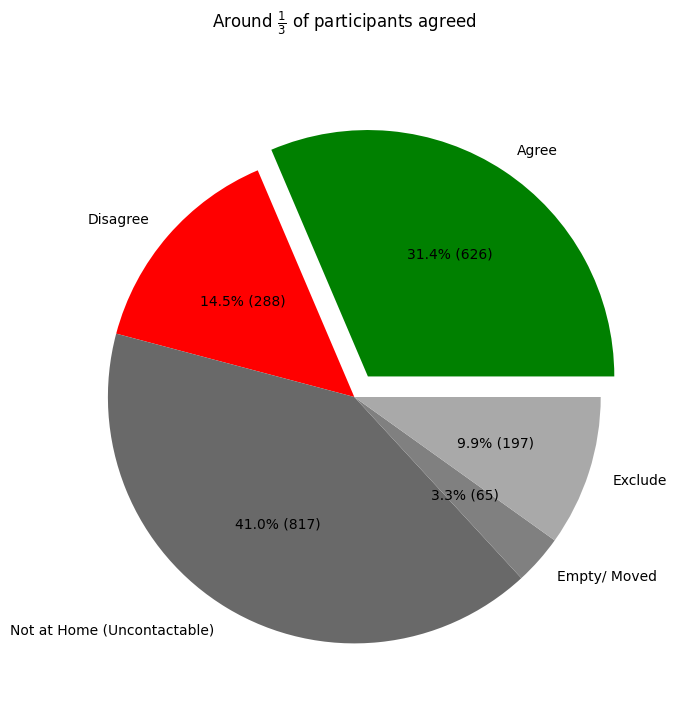

In [5]:
""" Make a pie chart showing how many people accepted """
import numpy as np
import matplotlib.pyplot as plt

# Count how many people in each category
response_codes, counts = np.unique(
    qnaire_answers["respondent_status"], return_counts=True
)

response_lookup = read.qnaire_status_codebook()

labels = [response_lookup[code] for code in response_codes]

colours = ["green", "red", "dimgrey", "grey", "darkgrey", "lightgrey"]
percentages = [count / np.sum(counts) for count in counts]


# Display both the percentage and count in the pie chart labels
def pct_and_count(values: list):
    """Returns callable"""

    def formatted_pct(pct: float):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f"{pct:.1f}% ({val:d})"

    return formatted_pct


fig, axis = plt.subplots(figsize=(8, 8))
axis.pie(
    counts,
    explode=[0.1, *[0.0] * (len(counts) - 1)],
    labels=labels,
    colors=colours,
    autopct=pct_and_count(counts),
)

fig.suptitle(r"Around $\frac{1}{3}$ of participants agreed")

In [6]:
"""
We only have more detailed demographic information for the participants who agreed to take part; so just
drop everyone else from the dataframe.

"""
qnaire_answers = qnaire_answers[qnaire_answers["respondent_status"] == 1]

In [7]:
"""
We also want to track the ages, but want to bin them into groups

Here we'll create a new column in the dataframe called `age_group`, and then populate it with an integer indicating
which age group they're in

"""
qnaire_answers["age_group"] = 0
age_bins = (7, 10, 13, 15)

age_col = qnaire_answers.loc[:, "age_dob"]

for age in age_bins[1:]:
    qnaire_answers.loc[age_col >= age, "age_group"] += 1

# Just print some information
print(qnaire_answers["age_group"].value_counts().sort_index())
print(qnaire_answers["age_dob"].value_counts().sort_index())

age_group
0    109
1    178
2    132
3    207
Name: count, dtype: int64
age_dob
7.0      5
8.0     41
9.0     63
10.0    60
11.0    57
12.0    61
13.0    75
14.0    57
15.0    76
16.0    63
17.0    67
18.0     1
Name: count, dtype: int64


/tmp/ipykernel_15653/1277433301.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qnaire_answers["age_group"] = 0


(<Figure size 640x480 with 3 Axes>,
 {('1.0', '3'): (0.0, 0.0, 0.6562898377374525, 0.3205356506873709),
  ('1.0', '0'): (0.0,
   0.3238359807203742,
   0.6562898377374525,
   0.1780753614929838),
  ('1.0', '2'): (0.0,
   0.5052116722463613,
   0.6562898377374525,
   0.21843911009806025),
  ('1.0', '1'): (0.0,
   0.7269511123774248,
   0.6562898377374525,
   0.2730488876225752),
  ('5.0', '3'): (0.6612159461118368, 0.0, 0.0015738365413367824, 0.0),
  ('5.0', '0'): (0.6612159461118368,
   0.0033003300330033004,
   0.0015738365413367824,
   0.9900990099009901),
  ('5.0', '2'): (0.6612159461118368,
   0.9966996699669967,
   0.0015738365413367824,
   0.0),
  ('5.0', '1'): (0.6612159461118368, 1.0, 0.0015738365413367824, 0.0),
  ('2.0', '3'): (0.6677158910275578,
   0.0,
   0.12433308676560854,
   0.26319087604963026),
  ('2.0', '0'): (0.6677158910275578,
   0.26649120608263355,
   0.12433308676560854,
   0.18799348289259307),
  ('2.0', '2'): (0.6677158910275578,
   0.45778501900822993,
   0

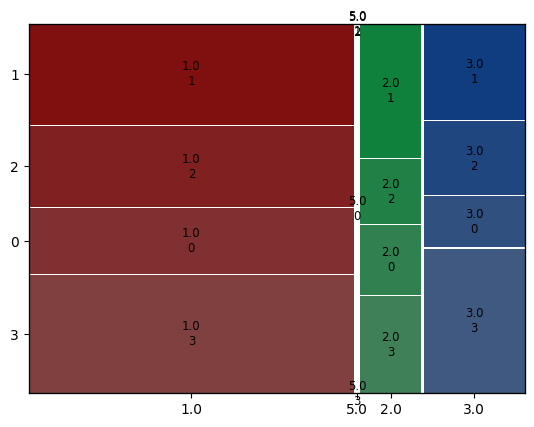

In [63]:
from statsmodels.graphics.mosaicplot import mosaic

mosaic(qnaire_answers, ["respondent_ethnicity", "age_group"])